# 第５章 計算機を作る



## 5.1.2 スタックマシン

In [1]:
def calc(expression: str):
    # 空白で分割して字句にする 
    tokens = expression.split() 
    stack = []
    for token in tokens:
        if token.isdigit():
            # 数値はスタックに push する 
            stack.append(int(token)) 
            continue
        # 数値でないなら，演算子として処理する 
        x = stack.pop()
        y = stack.pop()
        if token == '+':
            stack.append(x+y) 
        elif token == '*':
            stack.append(x*y)
    return stack.pop()

calc('1 2 + 2 3 + *')



15

In [2]:
# !pip install pegtree
import pegtree as pg
from pegtree.colab import peg, pegtree, example

構文木を表示するためには、graphviz があらかじめインストールされている必要がある。

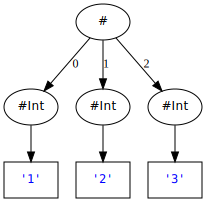

In [3]:
%%peg
Expr = Prod ("+" Prod)*
Prod = Value ("*" Value)*
Value = { [0-9]+ #Int } _

example Expr 1+2+3

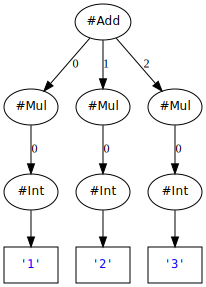

In [4]:
%%peg

Expr = { Prod ("+" Prod)* #Add }
Prod = { Value ("*" Value)* #Mul }
Value = { [0-9]+ #Int } _

example Expr 1+2+3

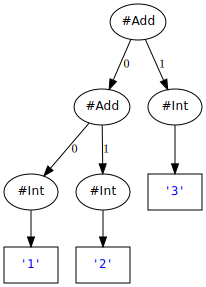

In [6]:
%%peg

Expr = Prod {^ "+" Prod #Add }*
Prod = Value {^ "*" Value #Mul }*
Value = { [0-9]+ #Int } _

example Expr 1+2+3

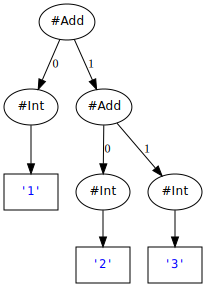

In [10]:
%%peg

Expr = Prod {^ "+" Prod #Add }* 
Prod = Value {^ "*" Value #Mul }* 
Value = "(" Expr ")" / Int
Int = { [0-9]+ #Int} _

example Expr 1+(2+3)

## PegTree によるパーザ生成

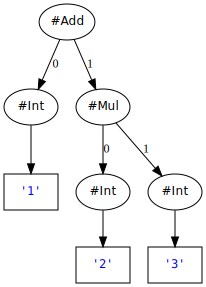

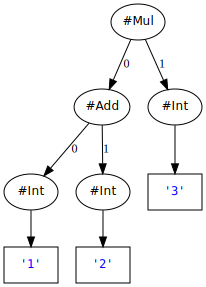

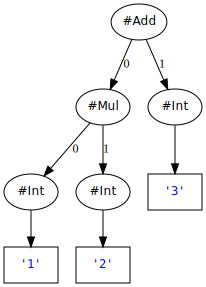

wrote calc.pegtree


In [12]:
%%peg calc.pegtree

Start = Expr EOF // 未消費文字を構文エラーに
Expr = Prod ({^ "+" Prod #Add } / {^ "-" Prod #Sub } )*
Prod = Value ({^ "*" Value #Mul  } / {^ "/" Value #Div  } )* 
Value = { [0-9]+ #Int} _ / "(" Expr ")"
example Expr 1+2*3
example Expr (1+2)*3
example Expr 1*2+3

## PegTree 文法のロード

In [13]:
peg = pg.grammar('calc.pegtree')

In [17]:
GRAMMAR = '''
Start = Expr EOF
Expr = Prod ({^ "+" Prod #Add } / {^ "-" Prod #Sub } )*
Prod = Value ({^ "*" Value #Mul  } / {^ "/" Value #Div  } )* 
Value = { [0-9]+ #Int} _ / "(" Expr ")"
'''
peg = pg.grammar(GRAMMAR)

In [15]:
peg['Expr']

Prod ({ ^ "+" Prod #Add } / { ^ "-" Prod #Sub })*

## 5.3.2 パーザの生成

In [18]:
parser = pg.generate(peg)

In [19]:
tree = parser('1+2') 
print(repr(tree))

[#Add [#Int '1'][#Int '2']]


In [20]:
tree = parser('3@14') 
print(repr(tree))

Syntax Error ((unknown source):1:1+1)
3@14
 ^  


## 構文木とVisitor パターン

In [21]:
peg = pg.grammar('calc.pegtree') 
parser = pg.generate(peg)
tree = parser('1+2*3')

In [22]:
tree.getTag()

'Add'

In [23]:
len(tree)

2

In [24]:
left = tree[0]
left.getTag()

'Int'

In [25]:
left = tree[0]
str(left)

'1'

In [26]:
def calc(tree):
    tag = tree.getTag() 
    if tag == 'Add':
        t0 = tree[0]
        t1 = tree[1]
        return calc(t0) + calc(t1)
    if tag == 'Mul': 
        t0 = tree[0] 
        t1 = tree[1]
        return calc(t0) * calc(t1) 
    if tag == 'Int':
        token = tree.getToken()
        return int(token)
    print(f'TODO: {tag}') # 未実装のタグの報告 
    return 0

tree = parser('1+2*3') 
print(calc(tree))

7


## Visitor パターン

In [29]:
class Visitor(object):
    def visit(self, tree):
        tag = tree.getTag()
        name = f'accept{tag}'
        if hasattr(self, name): # accept メソッドがあるか調べる
        # メソッド名からメソッドを得る 
            acceptMethod = getattr(self, name) 
            return acceptMethod(tree)
        print(f'TODO: accept{tag} method') 
        return None

In [34]:
class Calc(Visitor): # Visitor の継承 
    
    def __init__(self, parser):
        self.parser = parser
    
    def eval(self, source):
        tree = self.parser(source)
        return self.visit(tree)
    
    def acceptInt(self, tree):
        token = tree.getToken()
        return int(token)
    
    def acceptAdd(self, tree):
        t0 = tree.get(0)
        t1 = tree.get(1)
        v0 = self.visit(t0)
        v1 = self.visit(t1)
        return  v0 + v1
    
    def acceptMul(self, tree):
        t0 = tree.get(0)
        t1 = tree.get(1)
        v0 = self.visit(t0)
        v1 = self.visit(t1)
        return v0 * v1
    
    def accepterr(self, tree):
        print(repr(tree))
        raise SyntaxError()

In [35]:
calc = Calc(parser)
print(calc.eval("1+2*3"))
print(calc.eval("(1+2)*3"))
print(calc.eval("1*2+3"))

7
9
5


In [36]:
calc.eval('1@2')

Syntax Error ((unknown source):1:1+1)
1@2
 ^ 


SyntaxError: None (<string>)